In this explainer i have tried to structure the notebook as instructed, but this also mean that the reader have to skroll a lot, since some parts fit best at the bottom of the eaxplainer.

## Motivation

This project analyzes crime data across Danish municipalities using two datasets from Statistics Denmark:

* **STRAF47**: "Unsuspended sentence by region, sex, age, type of offence, type of decision and length of sentence"
* **FOLK1A**: "Population at the first day of the quarter by region, sex, age and marital status"

The primary goal is to explore spatial, demographic, and temporal patterns in crime — and to build visual narratives that highlight meaningful differences and trends.

We chose to focus specifically on the **municipality level** to make the analysis more actionable and relevant for local decision-making. Within the crime dataset, we filtered for overall offence totals per gender to focus on broader trends rather than the complexities of legal categories. Our time frame spans from **2008 to 2024**, chosen as the overlapping period between the crime and population data. Gender disaggregation allowed us to explore one of the most consistent findings in criminology: the gender gap in crime involvement.

Using data from Statistics Denmark ensures high quality and national representativeness. While the datasets lack individual-level resolution, their breadth and consistency over time offer strong potential for uncovering structural patterns in crime.

The intended user experience is exploratory and visual. We aimed to make the differences in crime across municipalities, over time, and between genders more tangible. Later, we extend the analysis using machine learning to evaluate whether crime rates — especially for men — can be predicted based on population size, year, and location.


## Load and clean crime data and basic stastics

In [177]:
import pandas as pd
import plotly.express as px

# Load clean Excel file
file_path = r"C:/Users/Baxe/Documents/SocialDataanalyseVisulisation/sentenceWithPopulation5.xlsx"
df = pd.read_excel(file_path, sheet_name='STRAF47')

# Melt to long format
df_melted = df.melt(id_vars=["Offence", "Gender", "Municipality"],
                    var_name="Year",
                    value_name="Count")

# Convert year and count
df_melted["Year"] = df_melted["Year"].astype(int)
df_melted["Count"] = pd.to_numeric(df_melted["Count"], errors="coerce")

# Remove 2007
df_melted = df_melted[df_melted["Year"] > 2007]

# Optional: Keep only total offences, all genders
df_melted = df_melted[df_melted["Offence"] == "Nature of the offence, total"]


# Standardize municipality names
df_melted["Municipality"] = df_melted["Municipality"].str.lower().str.strip()

# --- Basic Stats ---

# Number of unique municipalities, years, and gender groups
num_municipalities = df_melted["Municipality"].nunique()
num_years = df_melted["Year"].nunique()
year_range = (df_melted["Year"].min(), df_melted["Year"].max())
gender_counts = df_melted["Gender"].value_counts()

# Summary stats for Count (offences)
count_stats = df_melted["Count"].describe()

print(" Basic Statistics Overview")
print(f"- Number of unique municipalities: {num_municipalities}")
print(f"- Number of years: {num_years} (from {year_range[0]} to {year_range[1]})")
print(f"- Gender distribution:\n{gender_counts}")
print("\n Summary statistics for offence counts:")
print(count_stats)



 Basic Statistics Overview
- Number of unique municipalities: 100
- Number of years: 17 (from 2008 to 2024)
- Gender distribution:
All      1700
Men      1700
Women    1700
Name: Gender, dtype: int64

 Summary statistics for offence counts:
count    5100.000000
mean       61.923529
std       161.230350
min         0.000000
25%         4.000000
50%        30.000000
75%        67.000000
max      2373.000000
Name: Count, dtype: float64


## Load and Prepare Population Data

In [176]:
# Load the full sheet
df_raw = pd.read_excel(file_path, sheet_name="Residents")

# Only keep rows where the first column is 'I alt' (total population per municipality)
df_raw = df_raw[df_raw.iloc[:, 0].str.lower().str.strip() == "i alt"].copy()

# Rename the second column (index 1) to 'Municipality'
df_raw.rename(columns={df_raw.columns[1]: "Municipality"}, inplace=True)

# Clean municipality names
df_raw["Municipality"] = df_raw["Municipality"].str.lower().str.strip()

# Melt to long format
df_pop = df_raw.melt(id_vars="Municipality", var_name="Year", value_name="Population")

# Keep only valid 4-digit years
df_pop = df_pop[df_pop["Year"].astype(str).str.match(r"^\d{4}$")]

# Convert types
df_pop["Year"] = df_pop["Year"].astype(int)
df_pop["Population"] = pd.to_numeric(df_pop["Population"], errors="coerce")


# --- Basic Stats for Population Data ---

# Number of unique municipalities and years
num_munis_pop = df_pop["Municipality"].nunique()
num_years_pop = df_pop["Year"].nunique()
year_range_pop = (df_pop["Year"].min(), df_pop["Year"].max())

# Summary stats for population
pop_stats = df_pop["Population"].describe()

print(" Population Data Overview")
print(f"- Number of unique municipalities: {num_munis_pop}")
print(f"- Number of years: {num_years_pop} (from {year_range_pop[0]} to {year_range_pop[1]})")

print("\n Summary statistics for population:")
print(pop_stats)



 Population Data Overview
- Number of unique municipalities: 99
- Number of years: 17 (from 2008 to 2024)

 Summary statistics for population:
count      1683.000000
mean      57650.697564
std       69105.388867
min          78.000000
25%       29624.000000
50%       42989.000000
75%       59923.000000
max      659350.000000
Name: Population, dtype: float64


## Basic Statistics

To begin our analysis, we explored the structure and content of our two core datasets: **unsuspended sentence data (STRAF47)** and **population data (FOLK1A)** from Statistics Denmark. These datasets form the foundation for our crime rate calculations across Danish municipalities from 2008 to 2024.

#### Crime Data

The dataset contains information on unsuspended sentences for 100 municipalities over 17 years (2008–2024), split by gender. The gender distribution is well balanced across the three groups — *All*, *Men*, and *Women* — with 1,700 observations each.

A summary of offence counts reveals a highly skewed distribution:

* The **mean number of offences** is around 62, while the **maximum reaches 2,373**.
* 25% of values are **below 4**, and 75% are **below 67**, indicating that most municipalities record relatively low offence volumes in most years.
* The **standard deviation** is large (≈161), reflecting a high variance between small rural municipalities and larger urban areas.

This variability underlines the importance of **population-standardized measures** when comparing crime rates geographically.

#### Population Data

The population dataset covers 99 municipalities across the same 17-year period. Key observations include:

* Populations range from **just 78** residents (e.g., Christiansø) to **over 659,000** (Copenhagen).
* The **median municipality size** is approximately **43,000 residents**.
* As expected, the **population distribution is right-skewed**, with a small number of large municipalities driving the upper end of the range.

These basic statistics validate that municipalities differ drastically in size and crime volume, and reinforce the decision to use *crime per 10,000 residents* as our core metric for fair comparison.


# Merging datasets

In [149]:
# Ensret formatering
df_melted["Municipality"] = df_melted["Municipality"].str.lower().str.strip()
df_pop["Municipality"] = df_pop["Municipality"].str.lower().str.strip()

# Merge directly without groupby, since df_pop is already clean
df_merged = df_melted.merge(df_pop, on=["Municipality", "Year"], how="left")


In [150]:
# Filtrér til ønsket periode
df_period = df_merged[(df_merged["Year"] >= 2008) & (df_merged["Year"] <= 2024)].copy()

# Fjern rækker med manglende tal
df_period = df_period.dropna(subset=["Population", "Count"])

# Beregn kriminalitetsrate per 10.000
df_period["Crime_rate_per_10000"] = df_period["Count"] / df_period["Population"] * 10000

# Beregn gennemsnitlig kriminalitetsrate per kommune
df_avg = df_period.groupby("Municipality", as_index=False)["Crime_rate_per_10000"].mean()

# Sortér for top og bund
df_avg_sorted = df_avg.sort_values(by="Crime_rate_per_10000", ascending=False)

top5 = df_avg_sorted.head(5)
bottom5 = df_avg_sorted.tail(5)

# Udskriv resultater
print("Top 5 kommuner med højeste gennemsnitlige kriminalitetsrate (2008–2024):")
print(top5)

print("\nBund 5 kommuner med laveste gennemsnitlige kriminalitetsrate (2008–2024):")
print(bottom5)


Top 5 kommuner med højeste gennemsnitlige kriminalitetsrate (2008–2024):
    Municipality  Crime_rate_per_10000
56       lolland             17.071714
9        brøndby             15.559059
30  guldborgsund             14.515389
46         ishøj             13.760686
67        odense             13.107419

Bund 5 kommuner med laveste gennemsnitlige kriminalitetsrate (2008–2024):
   Municipality  Crime_rate_per_10000
66        odder              3.195563
78  skanderborg              3.191563
44     hørsholm              2.904524
16         fanø              2.854445
11  christiansø              0.000000


# Begining of Analysis

Our analysis focused on understanding the spatial, temporal, and demographic patterns of crime in Danish municipalities. We began by calculating the **crime rate per 10,000 residents** using two official datasets: one detailing unsuspended criminal sentences and the other showing population size. This allowed us to normalize crime counts across municipalities of vastly different sizes, enabling fair comparisons.

#### Key Findings

1. **Geographic Differences**:
   We identified significant disparities between municipalities. For instance, **Lolland, Brøndby, Guldborgsund, Ishøj, and Odense** consistently had the highest average crime rates, while **Odder, Skanderborg, Hørsholm, Fanø, and Christiansø** had the lowest. These patterns persisted across multiple years.

2. **Temporal Trends**:
   Several municipalities showed peaks around 2012–2013, followed by declining or stabilizing trends. For example, Odense’s crime rate dropped significantly after 2015, unlike the others in the Top 5 group, which remained volatile.

3. **Gender Differences**:
   A major takeaway was the **gender gap in crime**. Men were responsible for the vast majority of offences across all municipalities and offence types. Female crime rates were consistently low — often under 1 per 10,000 residents — with slightly higher involvement in property-related crimes and special acts.

4. **Offence Types**:
   In high-crime municipalities, **violent crimes** dominated the offence types, particularly in Lolland and Guldborgsund. In contrast, the Bottom 5 municipalities showed very low offence counts across all categories, with **traffic violations** and **sexual offences** being slightly more prominent.

5. **Volatility**:
   Municipalities with high average crime rates also exhibited greater **year-to-year volatility**, measured via the standard deviation of their crime rates. This suggests more unstable social or enforcement dynamics.

---

### Machine Learning Component

To further explore predictability, we developed a **Random Forest Regression model** using features such as municipality, year, gender, and population size. Our target variable was the **crime rate per 10,000 residents**. After training and evaluating the model, we found:

* **R² Score**: 0.78
* **RMSE**: 2.55

This indicates **good predictive performance**. The model captured much of the variance in crime rates, particularly for **male offenders**, who dominate the dataset. We chose to focus on male crime rates in the model to reduce noise and bias introduced by low female crime counts.

### Ekstra thoughts

One key insight we gained during the analysis is the **limitation of aggregate data**. While we worked with large datasets covering crime, education, and income, the only common link between them was the **municipality**. This significantly restricts the types of relationships and patterns we can explore. For instance, we are unable to analyze whether individuals with lower educational attainment are more likely to commit crimes or how income correlates with sentencing — because we **lack individual-level data**. If access to microdata were possible (e.g. anonymized personal records), we could have applied more advanced techniques such as clustering, causal inference, or classification to uncover **deeper, person-level patterns** behind criminal behavior.



## Plotting top and bottom 5 municipalities

In [ ]:
# Capitalize and sort
combined = pd.concat([top5, bottom5])
combined["Municipality"] = combined["Municipality"].str.title()
combined_sorted = combined.sort_values("Crime_rate_per_10000", ascending=False)

# Label top/bottom group
combined_sorted["Group"] = ["Top 5"] * 5 + ["Bottom 5"] * 5

color_map = {
    "Top 5": "#D62728",   # refined green
    "Bottom 5": "#2CA02C" # refined red
}



# Create Plotly bar chart
fig = px.bar(
    combined_sorted,
    x="Municipality",
    y="Crime_rate_per_10000",
    color="Group",
    color_discrete_map=color_map,
    text="Crime_rate_per_10000",
    title="Average Crime Rate per 10,000 Residents<br><sup>Top 5 vs Bottom 5 Municipalities (2008–2024)</sup>"
)

# Style text and layout
fig.update_traces(texttemplate='%{text:.1f}', textposition='outside')
fig.update_layout(
    title_font_size=20,
    title_x=0.5,
    yaxis_title="Crime Rate per 10,000",
    xaxis_title=None,
    xaxis_tickangle=-30,
    font=dict(family="Arial", size=14),
    plot_bgcolor="white",
    bargap=0.3,
    height=500
)
fig.write_html(r"C:\Users\Baxe\Documents\SocialDataanalyseVisulisation\signedue.github.io\crime_rates_plotly.html")
fig.show()



## For male and female


### Data preperation

In [156]:
# Filter for Men and Women separately (keeping only rows with total offence category)
df_men = df_merged[
    (df_merged["Gender"].str.lower() == "men") &
    (df_merged["Offence"].str.lower().str.strip() == "nature of the offence, total")
].copy()

df_women = df_merged[
    (df_merged["Gender"].str.lower() == "women") &
    (df_merged["Offence"].str.lower().str.strip() == "nature of the offence, total")
].copy()

print(df_women)
# Compute crime rate per 10,000 residents
for df_sex in [df_men, df_women]:
    df_sex["Crime_rate_per_10000"] = df_sex["Count"] / df_sex["Population"] * 10000

# Calculate average crime rate per municipality (2008–2024)
men_avg = (
    df_men[df_men["Year"].between(2008, 2024)]
    .groupby("Municipality", as_index=False)["Crime_rate_per_10000"]
    .mean()
    .assign(Gender="Men")
)

women_avg = (
    df_women[df_women["Year"].between(2008, 2024)]
    .groupby("Municipality", as_index=False)["Crime_rate_per_10000"]
    .mean()
    .assign(Gender="Women")
)

# Combine both genders
df_avg_gender = pd.concat([men_avg, women_avg], ignore_index=True)

# Clean municipality names for plot
df_avg_gender["Municipality"] = df_avg_gender["Municipality"].str.title()


                           Offence Gender             Municipality  Year  \
200   Nature of the offence, total  Women                københavn  2008   
201   Nature of the offence, total  Women            frederiksberg  2008   
202   Nature of the offence, total  Women                   dragør  2008   
203   Nature of the offence, total  Women                   tårnby  2008   
204   Nature of the offence, total  Women              albertslund  2008   
...                            ...    ...                      ...   ...   
5095  Nature of the offence, total  Women                   rebild  2024   
5096  Nature of the offence, total  Women                  thisted  2024   
5097  Nature of the offence, total  Women          vesthimmerlands  2024   
5098  Nature of the offence, total  Women                  aalborg  2024   
5099  Nature of the offence, total  Women  not stated municipality  2024   

      Count  Population  
200    55.0    509861.0  
201     5.0     93444.0  
202     0

## Plotting

In [ ]:
# Based on All
top5 = df_avg_sorted.head(5)["Municipality"].tolist()
bottom5 = df_avg_sorted.tail(5)["Municipality"].tolist()

# Filter for only top 5 and bottom 5 municipalities
df_top_bottom_gender = df_avg_gender[
    df_avg_gender["Municipality"].str.lower().isin(top5 + bottom5)
].copy()

# Assign group labels
df_top_bottom_gender["Group"] = df_top_bottom_gender["Municipality"].str.lower().apply(
    lambda m: "Top 5" if m in top5 else "Bottom 5"
)

# Sort for consistent display
df_top_bottom_gender_sorted = df_top_bottom_gender.sort_values(
    by=["Group", "Municipality", "Gender"]
)

# --- PLOTLY ---
import plotly.express as px

# Split the data
top_df = df_top_bottom_gender_sorted[df_top_bottom_gender_sorted["Group"] == "Top 5"]
bottom_df = df_top_bottom_gender_sorted[df_top_bottom_gender_sorted["Group"] == "Bottom 5"]

# --- TOP 5 ---
fig_top = px.bar(
    top_df,
    x="Municipality",
    y="Crime_rate_per_10000",
    color="Gender",
    barmode="group",
    title="Crime Rate per 10,000 Residents by Gender – Top 5 Municipalities",
    color_discrete_map={"Men": "#1f77b4", "Women": "#ff7f0e"},
    height=500
)
fig_top.update_layout(
    yaxis_title="Crime Rate per 10,000 Residents",
    font=dict(family="Arial", size=13),
    title_font_size=20,
    title_x=0.5,
    plot_bgcolor="white",
    bargap=0.3
)
fig_top.write_html(r"C:\Users\Baxe\Documents\SocialDataanalyseVisulisation\signedue.github.io\crime_gender_top.html")
fig_top.show()

# --- BOTTOM 5 ---
fig_bottom = px.bar(
    bottom_df,
    x="Municipality",
    y="Crime_rate_per_10000",
    color="Gender",
    barmode="group",
    title="Crime Rate per 10,000 Residents by Gender – Bottom 5 Municipalities",
    color_discrete_map={"Men": "#1f77b4", "Women": "#ff7f0e"},
    height=500
)
fig_bottom.update_layout(
    yaxis_title="Crime Rate per 10,000 Residents",
    font=dict(family="Arial", size=13),
    title_font_size=20,
    title_x=0.5,
    plot_bgcolor="white",
    bargap=0.3
)
fig_top.write_html(r"C:\Users\Baxe\Documents\SocialDataanalyseVisulisation\signedue.github.io\crime_gender_bottom.html")
fig_bottom.show()


## Time series for top and bottom 5

In [ ]:
# Extract actual yearly data for the top and bottom 5
top5_munis = top5["Municipality"].tolist()
bottom5_munis = bottom5["Municipality"].tolist()

# Filter from df_period (contains actual yearly crime rate per 10,000)
top5_timeseries = df_period[df_period["Municipality"].isin(top5_munis)]
bottom5_timeseries = df_period[df_period["Municipality"].isin(bottom5_munis)]

# --- TOP 5 TIME SERIES PLOT ---
fig_top = go.Figure()

for muni in top5_munis:
    muni_data = top5_timeseries[top5_timeseries["Municipality"] == muni]
    fig_top.add_trace(go.Scatter(
        x=muni_data["Year"],
        y=muni_data["Crime_rate_per_10000"],
        mode="lines+markers",
        name=muni.title()
    ))

fig_top.update_layout(
    title="Crime Rate Over Time – Top 5 Municipalities (2008–2024)",
    xaxis_title="Year",
    yaxis_title="Crime Rate per 10,000",
    legend_title="Municipality",
    template="plotly_white",
    font=dict(family="Arial", size=14),
    title_font_size=20,
    title_x=0.5,
    height=500
)

fig_top.write_html(r"C:\Users\Baxe\Documents\SocialDataanalyseVisulisation\signedue.github.io\crime_timeseries_top5.html")
fig_top.show()


# --- BOTTOM 5 TIME SERIES PLOT ---
fig_bottom = go.Figure()

for muni in bottom5_munis:
    muni_data = bottom5_timeseries[bottom5_timeseries["Municipality"] == muni]
    fig_bottom.add_trace(go.Scatter(
        x=muni_data["Year"],
        y=muni_data["Crime_rate_per_10000"],
        mode="lines+markers",
        name=muni.title()
    ))

fig_bottom.update_layout(
    title="Crime Rate Over Time – Bottom 5 Municipalities (2008–2024)",
    xaxis_title="Year",
    yaxis_title="Crime Rate per 10,000",
    legend_title="Municipality",
    template="plotly_white",
    font=dict(family="Arial", size=14),
    title_font_size=20,
    title_x=0.5,
    height=500
)

fig_bottom.write_html(r"C:\Users\Baxe\Documents\SocialDataanalyseVisulisation\signedue.github.io\crime_timeseries_bottom5.html")
fig_bottom.show()


## Crime votality top and bottom 5

In [ ]:
# top5["Municipality"] and bottom5["Municipality"]
selected_munis = top5["Municipality"].tolist() + bottom5["Municipality"].tolist()

# Filter to relevant municipalities
subset = df_period[df_period["Municipality"].isin(selected_munis)]

# Compute volatility (standard deviation of crime rate)
volatility = (
    subset
    .groupby("Municipality")["Crime_rate_per_10000"]
    .std()
    .reset_index()
    .rename(columns={"Crime_rate_per_10000": "CrimeRateVolatility"})
)

# Format
volatility["Municipality"] = volatility["Municipality"].str.title()
volatility["Group"] = volatility["Municipality"].str.lower().apply(
    lambda m: "Top 5" if m in top5["Municipality"].str.lower().tolist() else "Bottom 5"
)

volatility = volatility.sort_values("CrimeRateVolatility", ascending=False)

# Plot
fig = px.bar(
    volatility,
    x="Municipality",
    y="CrimeRateVolatility",
    color="Group",
    color_discrete_map={"Top 5": "#D62728", "Bottom 5": "#2CA02C"},
    title="Crime Rate Volatility (Standard Deviation)<br><sup>Top 5 vs Bottom 5 Municipalities</sup>",
    text="CrimeRateVolatility"
)

fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(
    title_x=0.5,
    yaxis_title="Standard Deviation per 10,000 Residents",
    font=dict(family="Arial", size=14),
    xaxis_tickangle=-30,
    height=500,
    plot_bgcolor="white"
)

# Save to HTML
fig.write_html(r"C:\Users\Baxe\Documents\SocialDataanalyseVisulisation\signedue.github.io\crime_volatility_top_bottom.html")
fig.show()


## Specific offences done by the top and bottom 5

#### Preparing the dataset
Only the 5 bottom and top municipalities and copenhagen were fetched. 
The totals of each offence type were extracted to get a total picture of the crime rate and which yype of crime was comitted.

In [ ]:

# Load the data
df = pd.read_excel(r"C:/Users/Baxe/Documents/SocialDataanalyseVisulisation/Assignment3/topBottomOffenceGender.xlsx")

# Strip column names
df.columns = df.columns.str.strip()

# Sum across all years
df['Total'] = df.loc[:, '2007':'2024'].sum(axis=1)

# Define top and bottom municipalities
top_munis = ['lolland', 'brøndby', 'guldborgsund', 'ishøj', 'odense']
bottom_munis = ['odder', 'skanderborg', 'hørsholm', 'fanø', 'christiansø']

# Assign group
df['Group'] = df['Municipality'].fillna('').str.lower().apply(
    lambda m: 'Top 5' if m in top_munis else 'Bottom 5' if m in bottom_munis else 'Other'
)

# Filter only Top 5 and Bottom 5 rows
df_filtered = df[df['Group'].isin(['Top 5', 'Bottom 5'])]

# Final summarized DataFrame
crime_by_muni = (
    df_filtered.groupby(['Group', 'Municipality', 'Offence'])['Total']
    .sum()
    .reset_index()
    .sort_values(['Group', 'Municipality', 'Total'], ascending=[True, True, False])
)

print(crime_by_muni.head(10))


       Group Municipality                              Offence  Total
0   Bottom 5  Christiansø  Andre straffelovsforbrydelser i alt      0
1   Bottom 5  Christiansø           Ejendomsforbrydelser i alt      0
2   Bottom 5  Christiansø                    Færdselslov i alt      0
3   Bottom 5  Christiansø            Seksualforbrydelser i alt      0
4   Bottom 5  Christiansø                        Særlove i alt      0
5   Bottom 5  Christiansø              Voldsforbrydelser i alt      0
11  Bottom 5         Fanø              Voldsforbrydelser i alt     22
7   Bottom 5         Fanø           Ejendomsforbrydelser i alt     12
8   Bottom 5         Fanø                    Færdselslov i alt      8
9   Bottom 5         Fanø            Seksualforbrydelser i alt      6


### Including population data

In [106]:
# First, ensure municipality names in df_pop match (lowercase)
df_pop['Municipality'] = df_pop['Municipality'].str.lower()

# Filter population for only the municipalities of interest
relevant_munis = top_munis + bottom_munis
df_pop_filtered = df_pop[df_pop['Municipality'].isin(relevant_munis)]

# Sum population from 2007 to 2024 for each municipality
pop_total = (
    df_pop_filtered[df_pop_filtered['Year'].between(2007, 2024)]
    .groupby("Municipality")["Population"]
    .sum()
    .reset_index()
    .rename(columns={"Population": "TotalPopulation"})
)

# Merge with crime data
crime_pop_offence = crime_by_muni.copy()
crime_pop_offence['Municipality'] = crime_pop_offence['Municipality'].str.lower()  # ensure match
crime_pop_offence = crime_pop_offence.merge(pop_total, on="Municipality", how="left")

# Calculate normalized crime rate
crime_pop_offence["CrimePer10k"] = crime_pop_offence["Total"] / crime_pop_offence["TotalPopulation"] * 10000

# Final sorting (optional)
crime_pop_offence = crime_pop_offence.sort_values(["Group", "Municipality", "CrimePer10k"], ascending=[True, True, False])

# View result
print(crime_pop_offence.head(10))


      Group Municipality                              Offence  Total  \
0  Bottom 5  christiansø  Andre straffelovsforbrydelser i alt      0   
1  Bottom 5  christiansø           Ejendomsforbrydelser i alt      0   
2  Bottom 5  christiansø                    Færdselslov i alt      0   
3  Bottom 5  christiansø            Seksualforbrydelser i alt      0   
4  Bottom 5  christiansø                        Særlove i alt      0   
5  Bottom 5  christiansø              Voldsforbrydelser i alt      0   
6  Bottom 5         fanø              Voldsforbrydelser i alt     22   
7  Bottom 5         fanø           Ejendomsforbrydelser i alt     12   
8  Bottom 5         fanø                    Færdselslov i alt      8   
9  Bottom 5         fanø            Seksualforbrydelser i alt      6   

   TotalPopulation  CrimePer10k  
0             1556     0.000000  
1             1556     0.000000  
2             1556     0.000000  
3             1556     0.000000  
4             1556     0.000000  
5  

### Plotting the 5 bottom and top municipalities

In [114]:
import plotly.express as px

# Copy and clean
plot_df = crime_pop_offence.copy()  # <- use the version with population and crime per 10k
# Map Danish offence labels to English
offence_translation = {
    "Seksualforbrydelser i alt": "Sexual offenses, total",
    "Voldsforbrydelser i alt": "Crimes of violence, total",
    "Ejendomsforbrydelser i alt": "Offences against property, total",
    "Andre Straffelovsforbrydelser i alt": "Other offences, total",
    "Færdselslov i alt": "The Road Traffic Act, total",
    "Særlove i alt": "Special acts, total"
}

# Apply to your offence labels
plot_df["Offence"] = plot_df["Offence"].replace(offence_translation)

plot_df['Municipality'] = plot_df['Municipality'].str.title()  # for color matching

# --- Top 5 plot ---
top_df_offence = plot_df[plot_df['Group'] == 'Top 5']

fig_top_offence = px.bar(
    top_df_offence,
    x="Offence",
    y="CrimePer10k",
    color="Municipality",
    color_discrete_map=color_map,
    barmode="group",
    title="Crime per 10,000 Residents by Type – Top 5 Municipalities",
    height=500
)

fig_top_offence.update_layout(
    xaxis_title="Type of Crime",
    yaxis_title="Crimes per 10,000 Residents (2007–2024)",
    font=dict(family="Arial", size=13),
    xaxis_tickangle=-45,
    plot_bgcolor="white",
    bargap=0.3,
)

fig_top_offence.write_html(r"C:\Users\Baxe\Documents\SocialDataanalyseVisulisation\signedue.github.io\crime_offence_top.html")

fig_top_offence.show()


# --- Bottom 5 plot ---
bottom_df_offence = plot_df[plot_df['Group'] == 'Bottom 5']

fig_bottom_offence = px.bar(
    bottom_df_offence,
    x="Offence",
    y="CrimePer10k",
    color="Municipality",
    color_discrete_map=color_map,
    barmode="group",
    title="Crime per 10,000 Residents by Type – Bottom 5 Municipalities",
    height=500
)

fig_bottom_offence.update_layout(
    xaxis_title="Type of Crime",
    yaxis_title="Crimes per 10,000 Residents (2007–2024)",
    font=dict(family="Arial", size=13),
    xaxis_tickangle=-45,
    plot_bgcolor="white",
    bargap=0.3,
)

fig_top_offence.write_html(r"C:\Users\Baxe\Documents\SocialDataanalyseVisulisation\signedue.github.io\crime_offence_bottom.html")
fig_bottom_offence.show()


### For male and female

In [ ]:
# Load the Excel data
df = pd.read_excel(r"C:/Users/Baxe/Documents/SocialDataanalyseVisulisation/Assignment3/topBottomOffenceGender.xlsx")
df.columns = df.columns.str.strip()

# Keep only 'Mænd' and 'Kvinder'
df = df[df['gender/total'].str.strip().isin(['Mænd', 'Kvinder'])]

# Sum across years
df['Total'] = df.loc[:, '2007':'2024'].sum(axis=1)

# Assign group: Top 5, Bottom 5, or Other
top_munis = ['lolland', 'brøndby', 'guldborgsund', 'ishøj', 'odense']
bottom_munis = ['odder', 'skanderborg', 'hørsholm', 'fanø', 'christiansø']
df['Municipality'] = df['Municipality'].str.lower().str.strip()
df['Group'] = df['Municipality'].apply(
    lambda m: 'Top 5' if m in top_munis else 'Bottom 5' if m in bottom_munis else 'Other'
)

# Filter only relevant municipalities
df_filtered = df[df['Group'].isin(['Top 5', 'Bottom 5'])]

# Group by gender
crime_gender_muni = (
    df_filtered.groupby(['Group', 'Municipality', 'gender/total', 'Offence'])['Total']
    .sum()
    .reset_index()
)

print(crime_gender_muni.head(10))


      Group Municipality gender/total                              Offence  \
0  Bottom 5  christiansø      Kvinder  Andre straffelovsforbrydelser i alt   
1  Bottom 5  christiansø      Kvinder           Ejendomsforbrydelser i alt   
2  Bottom 5  christiansø      Kvinder                    Færdselslov i alt   
3  Bottom 5  christiansø      Kvinder            Seksualforbrydelser i alt   
4  Bottom 5  christiansø      Kvinder                        Særlove i alt   
5  Bottom 5  christiansø      Kvinder              Voldsforbrydelser i alt   
6  Bottom 5  christiansø         Mænd  Andre straffelovsforbrydelser i alt   
7  Bottom 5  christiansø         Mænd           Ejendomsforbrydelser i alt   
8  Bottom 5  christiansø         Mænd                    Færdselslov i alt   
9  Bottom 5  christiansø         Mænd            Seksualforbrydelser i alt   

   Total  
0      0  
1      0  
2      0  
3      0  
4      0  
5      0  
6      0  
7      0  
8      0  
9      0  


In [116]:
# Ensure 'Municipality' is lowercase in both dataframes
df_pop['Municipality'] = df_pop['Municipality'].str.lower()
crime_gender_muni['Municipality'] = crime_gender_muni['Municipality'].str.lower()

# Filter population to only relevant municipalities and years
relevant_munis = top_munis + bottom_munis
df_pop_filtered = df_pop[df_pop['Municipality'].isin(relevant_munis)]
df_pop_filtered = df_pop_filtered[df_pop_filtered['Year'].between(2007, 2024)]

# Aggregate population by municipality and gender (same column name as in crime data)
# If your population data has gender information, you'll need to melt and match it accordingly.
# For now, we assume total population (without gender split):
pop_total = (
    df_pop_filtered
    .groupby("Municipality")["Population"]
    .sum()
    .reset_index()
    .rename(columns={"Population": "TotalPopulation"})
)

# Merge total population into crime + gender dataframe
crime_gender_pop = crime_gender_muni.merge(pop_total, on="Municipality", how="left")

# Normalize to crimes per 10,000 residents
crime_gender_pop["CrimePer10k"] = crime_gender_pop["Total"] / crime_gender_pop["TotalPopulation"] * 10000

# Sort result
crime_gender_pop = crime_gender_pop.sort_values(
    ["Group", "Municipality", "gender/total", "CrimePer10k"],
    ascending=[True, True, True, False]
)

# View top rows
print(crime_gender_pop.head(10))


      Group Municipality gender/total                              Offence  \
0  Bottom 5  christiansø      Kvinder  Andre straffelovsforbrydelser i alt   
1  Bottom 5  christiansø      Kvinder           Ejendomsforbrydelser i alt   
2  Bottom 5  christiansø      Kvinder                    Færdselslov i alt   
3  Bottom 5  christiansø      Kvinder            Seksualforbrydelser i alt   
4  Bottom 5  christiansø      Kvinder                        Særlove i alt   
5  Bottom 5  christiansø      Kvinder              Voldsforbrydelser i alt   
6  Bottom 5  christiansø         Mænd  Andre straffelovsforbrydelser i alt   
7  Bottom 5  christiansø         Mænd           Ejendomsforbrydelser i alt   
8  Bottom 5  christiansø         Mænd                    Færdselslov i alt   
9  Bottom 5  christiansø         Mænd            Seksualforbrydelser i alt   

   Total  TotalPopulation  CrimePer10k  
0      0             1556          0.0  
1      0             1556          0.0  
2      0          

In [120]:
# Copy and clean gender-based crime data
plot_df = crime_gender_pop.copy()

# Translate offence labels to English
offence_translation = {
    "Seksualforbrydelser i alt": "Sexual offenses",
    "Voldsforbrydelser i alt": "Crimes of violence",
    "Ejendomsforbrydelser i alt": "Offences against property",
    "Andre Straffelovsforbrydelser i alt": "Other offences",
    "Færdselslov i alt": "The Road Traffic Act",
    "Særlove i alt": "Special acts"
}
# Translate offence and gender labels to English
plot_df["Offence"] = plot_df["Offence"].replace(offence_translation)
plot_df["gender/total"] = plot_df["gender/total"].replace({"Mænd": "Male", "Kvinder": "Female"})
plot_df["Municipality"] = plot_df["Municipality"].str.title()
plot_df["MuniGender"] = plot_df["Municipality"] + " (" + plot_df["gender/total"] + ")"

# --- Top 5 plot ---
top_df = plot_df[plot_df["Group"] == "Top 5"]

fig_top = px.bar(
    top_df,
    x="Offence",
    y="CrimePer10k",
    color="MuniGender",
    barmode="group",
    title="Crime per 10,000 by Offence Type – Top 5 Municipalities (by Gender)",
    height=500
)

fig_top.update_layout(
    xaxis_title="Type of Crime",
    yaxis_title="Crimes per 10,000 Residents",
    xaxis_tickangle=-45,
    font=dict(family="Arial", size=13),
    plot_bgcolor="white",
    bargap=0.3,
)

fig_top.write_html(r"C:\Users\Baxe\Documents\SocialDataanalyseVisulisation\signedue.github.io\crime_offence_gender_top.html")
fig_top.show()


# --- Bottom 5 plot ---
bottom_df = plot_df[plot_df["Group"] == "Bottom 5"]

fig_bottom = px.bar(
    bottom_df,
    x="Offence",
    y="CrimePer10k",
    color="MuniGender",
    barmode="group",
    title="Crime per 10,000 by Offence Type – Bottom 5 Municipalities (by Gender)",
    height=500
)

fig_bottom.update_layout(
    xaxis_title="Type of Crime",
    yaxis_title="Crimes per 10,000 Residents",
    xaxis_tickangle=-45,
    font=dict(family="Arial", size=13),
    plot_bgcolor="white",
    bargap=0.3,
)

fig_bottom.write_html(r"C:\Users\Baxe\Documents\SocialDataanalyseVisulisation\signedue.github.io\crime_offence_gender_bottom.html")
fig_bottom.show()


## Predictive model

In [168]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# --- Prepare data ---
df_model = df_merged.copy()

# Filter only rows for Men and the total offence category
df_model = df_model[
    (df_model["Gender"].str.lower() == "men") &
    (df_model["Offence"].str.lower().str.strip() == "nature of the offence, total") &
    df_model["Population"].notna() &
    df_model["Count"].notna()
].copy()

# Calculate crime rate per 10,000 residents
df_model["CrimeRatePer10k"] = df_model["Count"] / df_model["Population"] * 10_000

# --- Define features and target ---
X = df_model[["Municipality", "Year", "Population"]]
y = df_model["CrimeRatePer10k"]

# --- Preprocessing ---
categorical_features = ["Municipality"]
numeric_features = ["Year", "Population"]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
], remainder="passthrough")

# --- Model pipeline ---
model = Pipeline([
    ("preprocess", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Fit model ---
model.fit(X_train, y_train)

# --- Predict and evaluate ---
y_pred = model.predict(X_test)

print(f"R² score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")


R² score: 0.781
RMSE: 2.55


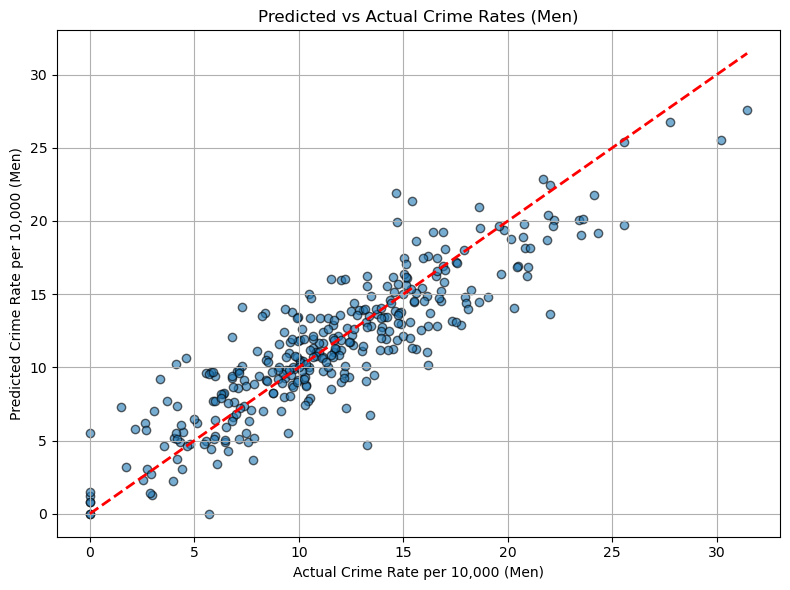

In [174]:
import matplotlib.pyplot as plt

# --- Predicted vs Actual Scatter Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Crime Rate per 10,000 (Men)")
plt.ylabel("Predicted Crime Rate per 10,000 (Men)")
plt.title("Predicted vs Actual Crime Rates (Men)")
plt.grid(True)
plt.tight_layout()

# Save as PNG
plt.savefig(r"C:\Users\Baxe\Documents\SocialDataanalyseVisulisation\signedue.github.io\crime_predicted1.png")

# Show plot
plt.show()


# Genre

The genre of data story we used is a **“Magazine Style” narrative** — combining structured text with visualizations to guide the reader through a series of insights. We structured the story around a series of visual blocks (charts, maps, tables), each supported by concise explanatory text that builds a coherent and informative flow. This format is ideal for audiences who want both visual exploration and clear interpretation.

---

### Visual Narrative Tools (Segal & Heer – Figure 7)

We used tools from all three categories of visual narrative to support engagement and comprehension:

* **Visual Structuring**

  * *Consistent Color*: We used fixed color palettes (e.g., consistent municipality colors) to help the user visually track patterns across plots.
  * *Small Multiples / Facets*: For comparing top 5 vs bottom 5 municipalities or male vs female, we used facet plots or side-by-side bar charts.
  * *Annotations / Labels*: Tooltips and axis titles help interpret the values in each chart.

* **Highlighting**

  * *Emphasis with Color*: Important groups (e.g., Top 5 vs Bottom 5) were highlighted in contrasting colors (e.g., red and green).
  * *Ordering / Sorting*: Bars were sorted to emphasize differences in crime rates.

* **Transitions**

  * *Progressive Disclosure*: We gradually revealed insights — starting with overall crime, then gender breakdowns, and finally predictive modeling.
  * *Zooming In*: After identifying high-crime areas, we zoomed into specific types of crime and gender patterns.

---

### Narrative Structure Tools (Segal & Heer – Figure 7)

We also applied tools from each narrative structure category:

* **Ordering**

  * *Chronological*: Crime trends over time were presented using line plots across years.
  * *Thematic Blocks*: The story is divided into sections like “Gender Differences,” “Crime Types,” and “Prediction.”

* **Interactivity / Control**

  * *Interactive Plots*: Users can hover to explore individual municipalities or years, using Plotly to allow dynamic exploration.

* **Messaging**

  * *Text Blocks*: Each chart is introduced with clear narrative text to guide interpretation.
  * *Headings & Captions*: Every visualization is accompanied by a meaningful title and explanation of what the user should take away.



# Visualisations

We carefully selected visualizations that support both exploration and storytelling. Each chart was designed to highlight key findings while allowing users to compare municipalities, crime types, and demographic patterns effectively.

* **Bar charts** were used to compare average crime rates across municipalities. This allowed us to clearly show the contrast between the top 5 and bottom 5 municipalities, and to break down the differences by gender and crime category.

* **Line plots** were used to visualize how crime rates changed over time in each municipality. These helped us identify trends such as spikes in 2012–2013 or the steady decline in some regions like Odense.

* **Grouped bar charts by gender** allowed us to compare male and female crime rates side by side. Since gender was a major factor in the data, this helped illustrate the magnitude of the gap.

* **Scatter plot of predicted vs actual crime rates** was used to evaluate our machine learning model. This made it easy to see how closely the model aligned with real-world crime rates, showing the effectiveness of our approach.

All visualizations were made interactive using Plotly, enabling users to hover and explore specific values — an important feature for public-facing data storytelling. Together, these plots build a coherent visual narrative from historical patterns to predictive insights.

# Discussion

Several aspects of our project worked well. The decision to focus on municipality-level data allowed us to create clear, interpretable visualizations and identify consistent geographical patterns in crime rates. By combining crime and population datasets, we were able to normalize offences per 10,000 residents — a crucial step for making meaningful comparisons across municipalities of very different sizes. The gender-based breakdowns revealed stark differences in crime involvement, and using interactive visualizations gave users a powerful way to explore those differences.

A key success was our machine learning model trained on male crime data. With an R² score of 0.78 and a low RMSE, it performed well in predicting crime rates based on demographic and temporal features. 

However, several limitations remain. First, the datasets only connect via municipality, which restricts how deeply we can analyze the relationships between crime, education, income, and other factors. Without individual-level or even household-level data, we cannot control for variables like age, education, or income directly. Second, the dataset contains only reported crimes — not necessarily all crimes committed — and changes in reporting behavior over time could distort observed trends.

Additionally, the crime categories are quite broad, especially in the "Special Acts" and "Other Offences" groups. A more granular breakdown would allow deeper insight into what types of crime are most common or increasing. On the technical side, while our model performs well, it could potentially be improved with more advanced models like XGBoost or temporal models like LSTM.

Finally, from a design standpoint, while the notebook contains thorough visualizations, integrating them into a narrative flow for a public audience required balancing simplicity and depth. Some complex findings may benefit from additional contextual explanation or interactivity in a full web app format.


# Contributions
Signe Dueholm Nielsen found and extracted the data. The group aggreed on the directions. Then Signe did everything in this notebook.